In [6]:
import json
from collections import defaultdict

from scapy.all import rdpcap, DNSRR, DNS, IP
from tqdm import tqdm

In [4]:
with open('data/tokyo_hosts.json', 'r') as f:
    tokyo_hosts = json.loads(f.read())

## Plotting bytes sent from each host

In [23]:
def count_packets(pcap_file):
    stats = defaultdict(lambda: {
        "num_sent": 0, 
        "bytes_sent": 0,
        "num_recieved": 0,
        "bytes_recieved": 0
    })

    # packets = rdpcap(pcap_file, count=10000)
    packets = rdpcap(pcap_file)

    for packet in tqdm(packets):
        # Check if the packet has an IP layer
        if IP in packet:
            ip_src = packet[IP].src
            ip_dst = packet[IP].dst
            packet_length = len(packet)

            stats[ip_src]["num_sent"] += 1
            stats[ip_src]["bytes_sent"] += packet_length
            stats[ip_dst]["num_recieved"] += 1
            stats[ip_dst]["bytes_recieved"] += packet_length

    return stats


In [27]:
full_stats = count_packets('captures/tokyo_cache_block_test1.pcap')

100%|██████████| 56040/56040 [00:01<00:00, 30385.65it/s]


In [58]:
bytes_sent = {}
bytes_recieved = {}

for ip, ip_stats in sorted(full_stats.items(), key=lambda x: x[1]['bytes_sent'], reverse=True):
    host = str(ip)

    # our IP
    if host.startswith("172"):
        continue

    if ip in tokyo_hosts:
        host = tokyo_hosts[ip]

    # print(f"{host}: {ip_stats['bytes_sent']:,}")
    bytes_sent[host] = ip_stats['bytes_sent']
    bytes_recieved[host] = ip_stats['bytes_recieved']

In [59]:
data = bytes_sent

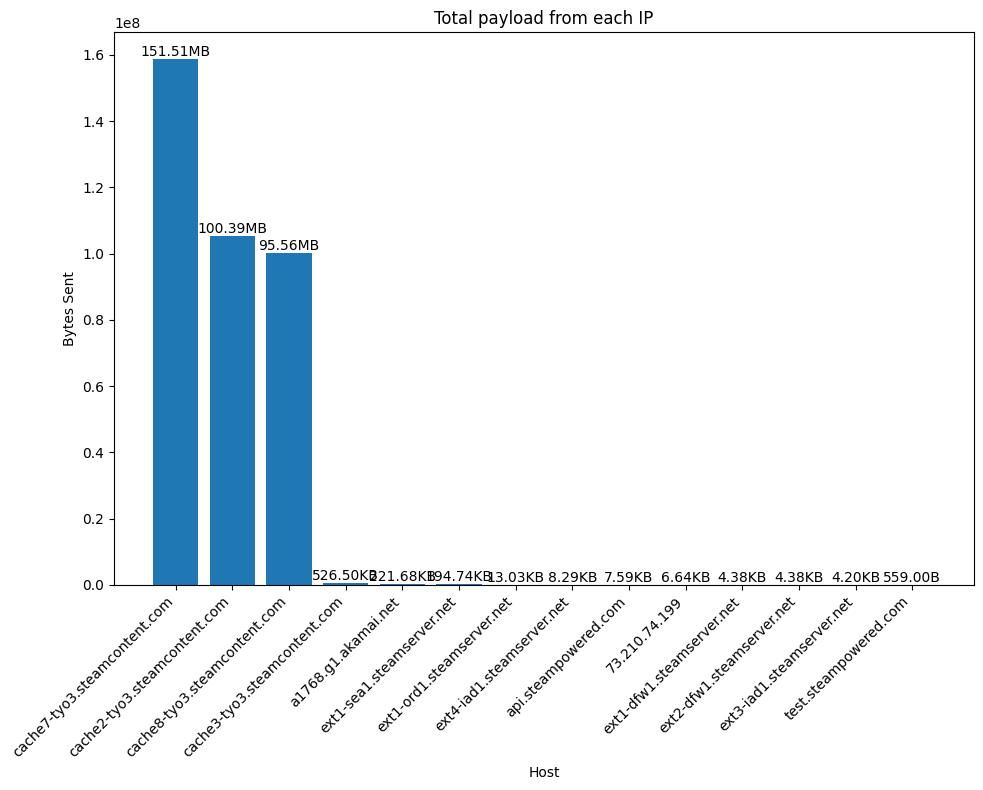

In [60]:
import matplotlib.pyplot as plt

# Function to convert bytes to a readable format
def bytes_to_readable(bytes):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if bytes < 1024:
            return f"{bytes:.2f}{unit}"
        bytes /= 1024
    return f"{bytes:.2f}PB"

# Filter out hosts with less than 100 bytes
filtered_data = {host: bytes for host, bytes in data.items() if bytes >= 500}

# Sort the data by byte count in descending order
sorted_data = dict(sorted(filtered_data.items(), key=lambda item: item[1], reverse=True))

# Convert bytes to a readable format for labeling
labels = [host for host in sorted_data]
byte_values = [sorted_data[host] for host in sorted_data]
readable_values = [bytes_to_readable(value) for value in byte_values]

# Plotting
plt.figure(figsize=(10, 8))
bars = plt.bar(labels, byte_values, tick_label=labels)
plt.xticks(rotation=45, ha="right")  # Rotate labels to avoid overlap

# Add labels to bars
for bar, value in zip(bars, readable_values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, value, ha='center', va='bottom')

plt.xlabel('Host')
plt.ylabel('Bytes Sent')
plt.title('Total payload from each IP')
plt.tight_layout()
plt.show()


## Timeline visualization

In [54]:
packets = rdpcap('captures/tokyo_cache_block_test1.pcap')

timestamps = defaultdict(list)

for packet in packets:
    if IP in packet:
        src_ip = packet[IP].src

        # our IP
        if src_ip.startswith("172"):
            continue

        timestamps[src_ip].append(packet.time)

In [55]:
# Convert absolute timestamps to relative timestamps with the first packet as the baseline
base_time = min(min(times) for times in timestamps.values())

for ip, times in timestamps.items():
    timestamps[ip] = [t - base_time for t in times]

# full list of events for plotting
hosts = [] 
events = [] 

for ip, timestamps in timestamps.items():
    if ip in tokyo_hosts:
        hosts.append(tokyo_hosts[ip])
    else:
        hosts.append(ip)
    events.append(timestamps)


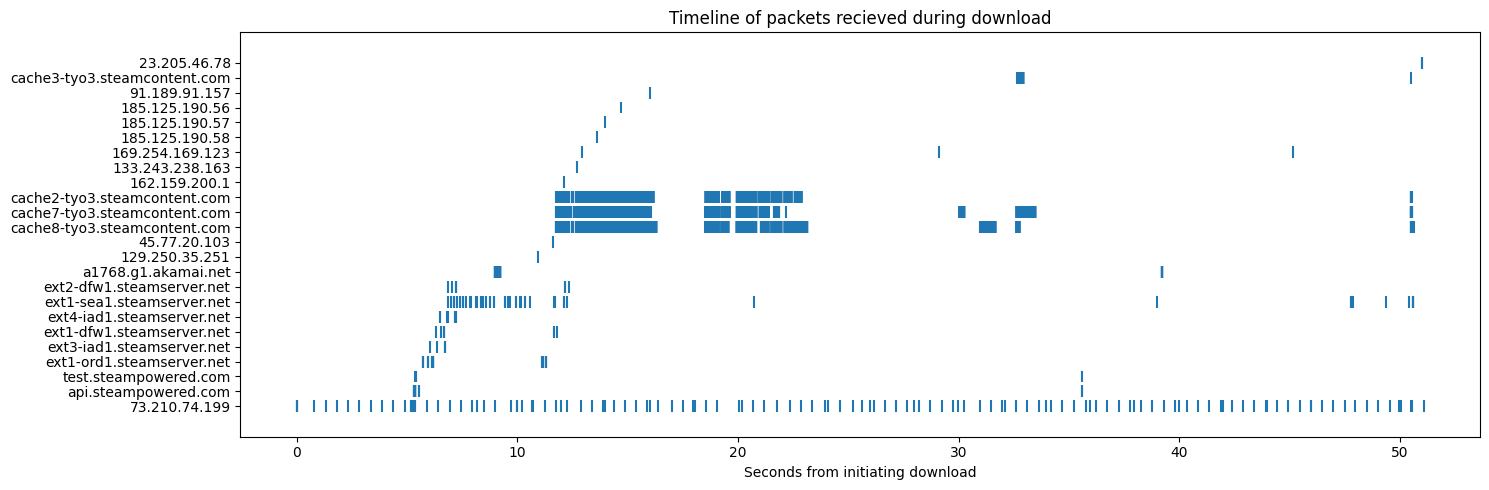

In [57]:
plt.figure(figsize=(15, 5))

for i, timestamps in enumerate(events):
    plt.eventplot(timestamps, lineoffsets=i, linelengths=0.8)

# Set the y-ticks to use the host labels
plt.yticks(range(len(hosts)), hosts)
plt.xlabel('Seconds from initiating download')

plt.title('Timeline of packets recieved during download')
plt.tight_layout()
plt.show()
